# Chapter 19: Code optimization

Robert Johansson

Source code listings for [Numerical Python - Scientific Computing and Data Science Applications with Numpy, SciPy and Matplotlib](https://link.springer.com/book/10.1007/979-8-8688-0413-7) (ISBN 979-8-8688-0412-0).

In [1]:
import numba

In [2]:
import pyximport

In [3]:
import cython

In [6]:
import numpy as np

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

# Numba

In [8]:
np.random.seed(0)

In [9]:
data = np.random.randn(50000)

In [10]:
def py_sum(data):
    s = 0
    for d in data:
        s += d
    return s

In [11]:
def py_cumsum(data):
    out = np.zeros(len(data), dtype=np.float64)
    s = 0 
    for n in range(len(data)):
        s += data[n]
        out[n] = s

    return out

In [12]:
%timeit py_sum(data)

2.99 ms ± 39.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
assert abs(py_sum(data) - np.sum(data)) < 1e-10

In [14]:
%timeit np.sum(data)

12.7 μs ± 164 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [15]:
%timeit py_cumsum(data)

6.44 ms ± 14.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
assert np.allclose(np.cumsum(data), py_cumsum(data))

In [17]:
%timeit np.cumsum(data)

106 μs ± 245 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
@numba.jit
def jit_sum(data):
    s = 0 
    for d in data:
        s += d

    return s

In [19]:
assert abs(jit_sum(data) - np.sum(data)) < 1e-10

In [20]:
%timeit jit_sum(data)

46 μs ± 22.2 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [21]:
jit_cumsum = numba.jit()(py_cumsum)

In [22]:
assert np.allclose(np.cumsum(data), jit_cumsum(data))

In [23]:
%timeit jit_cumsum(data)

52.9 μs ± 25.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Julia fractal

In [24]:
def py_julia_fractal(z_re, z_im, j):
    for m in range(len(z_re)):
        for n in range(len(z_im)):
            z = z_re[m] + 1j * z_im[n]
            for t in range(256):
                z = z ** 2 - 0.05 + 0.68j
                if np.abs(z) > 2.0:
                #if (z.real * z.real + z.imag * z.imag) > 4.0:  # a bit faster
                    j[m, n] = t
                    break

In [25]:
jit_julia_fractal = numba.jit(nopython=True)(py_julia_fractal)

In [26]:
N = 1024
j = np.zeros((N, N), np.int64)
z_real = np.linspace(-1.5, 1.5, N)
z_imag = np.linspace(-1.5, 1.5, N)

In [27]:
jit_julia_fractal(z_real, z_imag, j)

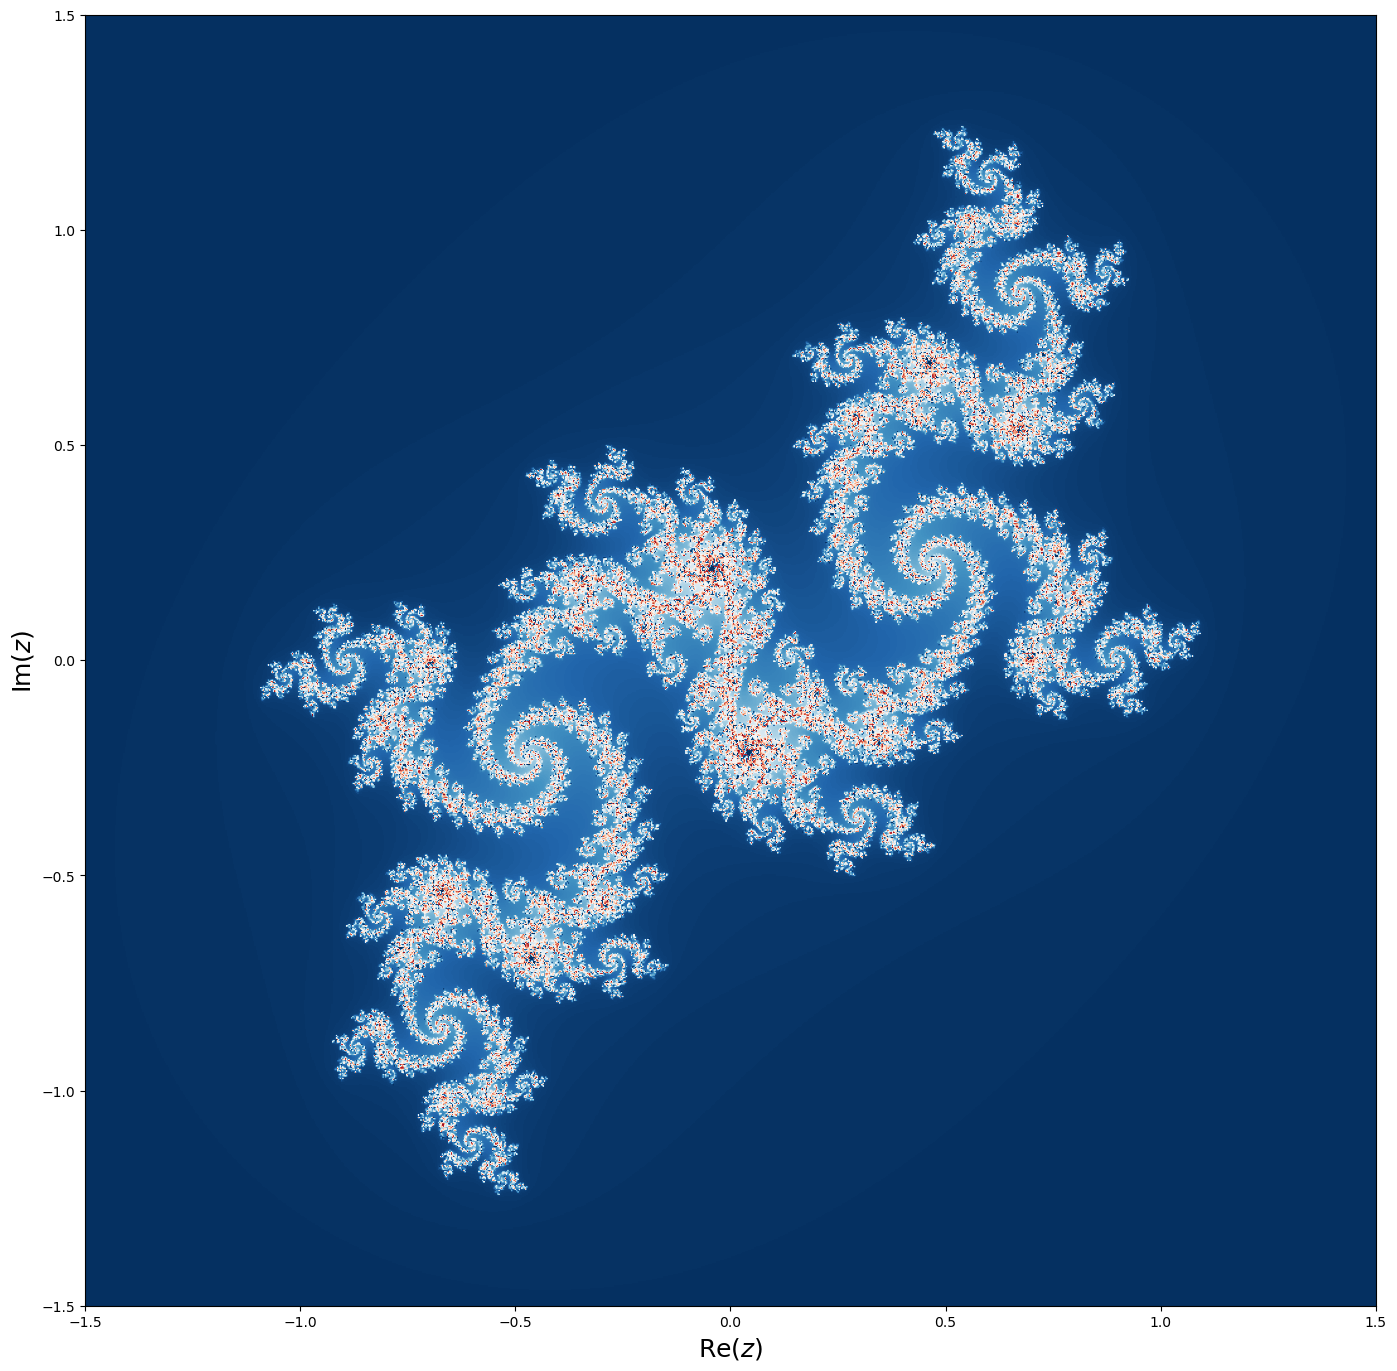

In [28]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(j, cmap=plt.cm.RdBu_r,
          extent=[-1.5, 1.5, -1.5, 1.5])
ax.set_xlabel("$\mathrm{Re}(z)$", fontsize=18)
ax.set_ylabel("$\mathrm{Im}(z)$", fontsize=18)
fig.tight_layout()
fig.savefig("ch19-numba-julia-fractal.pdf")

In [29]:
%timeit py_julia_fractal(z_real, z_imag, j)

15.6 s ± 82.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%timeit jit_julia_fractal(z_real, z_imag, j)

175 ms ± 567 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Vectorize

In [31]:
def py_Heaviside(x):
    if x == 0.0:
        return 0.5
    
    if x < 0.0:
        return 0.0
    else:
        return 1.0

In [32]:
x = np.linspace(-2, 2, 50001)

In [33]:
%timeit [py_Heaviside(xx) for xx in x]

6.44 ms ± 63.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
np_vec_Heaviside = np.vectorize(py_Heaviside)

In [35]:
np_vec_Heaviside(x)

array([0., 0., 0., ..., 1., 1., 1.])

In [36]:
%timeit np_vec_Heaviside(x)

4.93 ms ± 187 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
def np_Heaviside(x):
    return (x > 0.0) + (x == 0.0)/2.0

In [38]:
%timeit np_Heaviside(x)

81.3 μs ± 456 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [39]:
@numba.vectorize([numba.float32(numba.float32),
                  numba.float64(numba.float64)])
def jit_Heaviside(x):
    if x == 0.0:
        return 0.5
    
    if x < 0:
        return 0.0
    else:
        return 1.0

In [40]:
%timeit jit_Heaviside(x)

15.7 μs ± 368 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [41]:
jit_Heaviside([-1, -0.5, 0.0, 0.5, 1.0])

array([0. , 0. , 0.5, 1. , 1. ])

# Cython

In [42]:
!rm cy_sum.*

rm: cannot remove 'cy_sum.*': No such file or directory


In [43]:
%%writefile cy_sum.pyx

def cy_sum(data):
    s = 0.0
    for d in data:
        s += d
    return s

Writing cy_sum.pyx


In [44]:
!cython cy_sum.pyx

/opt/conda/lib/python3.11/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /home/rob/notebooks/cy_sum.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [45]:
# 5 lines of python code -> 1470 lines of C code ...
!wc cy_sum.c

  6126  19777 233611 cy_sum.c


In [46]:
%%writefile setup.py

from distutils.core import setup
from Cython.Build import cythonize

import numpy as np
setup(ext_modules=cythonize('cy_sum.pyx'),
      include_dirs=[np.get_include()],
      requires=['Cython', 'numpy'] )

Writing setup.py


In [52]:
!/opt/conda/envs/npbook_py310/bin/python setup.py build_ext --inplace > /dev/null

/opt/conda/envs/npbook_py310/lib/python3.10/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /home/rob/notebooks/cy_sum.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [53]:
from cy_sum import cy_sum

In [54]:
cy_sum(data)

-189.70046227549025

In [55]:
%timeit cy_sum(data)

2.44 ms ± 115 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
%timeit py_sum(data)

2.87 ms ± 71.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
%%writefile cy_cumsum.pyx

cimport numpy
import numpy

def cy_cumsum(data):
    out = numpy.zeros_like(data)
    s = 0 
    for n in range(len(data)):
        s += data[n]
        out[n] = s

    return out

Writing cy_cumsum.pyx


In [58]:
pyximport.install(setup_args={'include_dirs': np.get_include()});

In [59]:
pyximport.install(setup_args=dict(include_dirs=np.get_include()));

In [ ]:
from cy_cumsum import cy_cumsum

In [61]:
%timeit cy_cumsum(data)

5.94 ms ± 165 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [62]:
%timeit py_cumsum(data)

6.47 ms ± 41.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Using IPython cython command

In [63]:
%load_ext cython

In [64]:
%%cython -a
def cy_sum(data):
    s = 0.0
    for d in data:
        s += d
    return s

In [65]:
%timeit cy_sum(data)

2.57 ms ± 56.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [66]:
%timeit py_sum(data)

2.96 ms ± 107 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [67]:
assert np.allclose(np.sum(data), cy_sum(data))

In [68]:
%%cython -a
cimport numpy
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_sum(numpy.ndarray[numpy.float64_t, ndim=1] data):
    cdef numpy.float64_t s = 0.0
    #cdef int n, N = data.shape[0]
    cdef int n, N = len(data)
    for n in range(N):
        s += data[n]
    return s

Content of stderr:
In file included from /opt/conda/envs/npbook_py310/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /opt/conda/envs/npbook_py310/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/envs/npbook_py310/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/rob/.cache/ipython/cython/_cython_magic_16d506d9dddc3a141b0f412e0228a611fa6c09f1.c:1250:
/opt/conda/envs/npbook_py310/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

In [69]:
%timeit cy_sum(data)

46 μs ± 9.16 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [70]:
%timeit jit_sum(data)

46 μs ± 10.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [71]:
%timeit np.sum(data)

12.7 μs ± 14.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Cummulative sum

In [72]:
%%cython -a
cimport numpy
import numpy
cimport cython

ctypedef numpy.float64_t FTYPE_t

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_cumsum(numpy.ndarray[FTYPE_t, ndim=1] data):
    cdef int n, N = data.size
    cdef numpy.ndarray[FTYPE_t, ndim=1] out = numpy.zeros(N, dtype=data.dtype)
    cdef numpy.float64_t s = 0.0
    for n in range(N):
        s += data[n]
        out[n] = s
    return out

Content of stderr:
In file included from /opt/conda/envs/npbook_py310/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /opt/conda/envs/npbook_py310/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/envs/npbook_py310/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/rob/.cache/ipython/cython/_cython_magic_a7031120ac776f6c06c9d1ee05b4d71edd090747.c:1251:
/opt/conda/envs/npbook_py310/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

In [73]:
%timeit py_cumsum(data)

6.39 ms ± 28.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [74]:
%timeit cy_cumsum(data)

53.4 μs ± 113 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [75]:
%timeit jit_cumsum(data)

52.8 μs ± 11.8 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [76]:
%timeit np.cumsum(data)

107 μs ± 404 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [77]:
assert np.allclose(cy_cumsum(data), np.cumsum(data))

## Fused types

In [78]:
py_sum([1.0, 2.0, 3.0, 4.0, 5.0])

15.0

In [79]:
py_sum([1, 2, 3, 4, 5])

15

In [80]:
cy_sum(np.array([1.0, 2.0, 3.0, 4.0, 5.0]))

15.0

In [81]:
cy_sum(np.array([1, 2, 3, 4, 5]))

ValueError: Buffer dtype mismatch, expected 'float64_t' but got 'long'

In [82]:
%%cython -a
cimport numpy
cimport cython

ctypedef fused I_OR_F_t:
    numpy.int64_t 
    numpy.float64_t 

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_fused_sum(numpy.ndarray[I_OR_F_t, ndim=1] data):
    cdef I_OR_F_t s = 0
    cdef int n, N = data.size
    for n in range(N):
        s += data[n]
    return s

Content of stderr:
In file included from /opt/conda/envs/npbook_py310/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /opt/conda/envs/npbook_py310/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/envs/npbook_py310/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/rob/.cache/ipython/cython/_cython_magic_c9ea336cdf929fb6c33bee737b5729b0932d7e9d.c:1252:
/opt/conda/envs/npbook_py310/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

In [83]:
cy_fused_sum(np.array([1.0, 2.0, 3.0, 4.0, 5.0]))

15.0

In [84]:
cy_fused_sum(np.array([1, 2, 3, 4, 5]))

15

## Julia fractal

In [85]:
%%cython -a
cimport numpy
cimport cython

ctypedef numpy.int64_t ITYPE_t
ctypedef numpy.float64_t FTYPE_t

cpdef inline double abs2(double complex z):
    return z.real * z.real + z.imag * z.imag

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_julia_fractal(numpy.ndarray[FTYPE_t, ndim=1] z_re, 
                     numpy.ndarray[FTYPE_t, ndim=1] z_im, 
                     numpy.ndarray[ITYPE_t, ndim=2] j):
    cdef int m, n, t, M = z_re.size, N = z_im.size
    cdef double complex z
    for m in range(M):
        for n in range(N):
            z = z_re[m] + 1.0j * z_im[n]
            for t in range(256):
                z = z ** 2 - 0.05 + 0.68j
                if abs2(z) > 4.0:
                    j[m, n] = t
                    break

Content of stderr:
In file included from /opt/conda/envs/npbook_py310/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /opt/conda/envs/npbook_py310/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/envs/npbook_py310/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/rob/.cache/ipython/cython/_cython_magic_6898fa0f5546b1e4516bdba3309b213764481d6c.c:1253:
/opt/conda/envs/npbook_py310/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

In [86]:
N = 1024

In [87]:
j = np.zeros((N, N), dtype=np.int64)

In [88]:
z_real = np.linspace(-1.5, 1.5, N)

In [89]:
z_imag = np.linspace(-1.5, 1.5, N)

In [90]:
%timeit cy_julia_fractal(z_real, z_imag, j)

2.3 s ± 23.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:
%timeit jit_julia_fractal(z_real, z_imag, j)

169 ms ± 5.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [92]:
j1 = np.zeros((N, N), dtype=np.int64)

In [93]:
cy_julia_fractal(z_real, z_imag, j1)

In [94]:
j2 = np.zeros((N, N), dtype=np.int64)

In [95]:
jit_julia_fractal(z_real, z_imag, j2)

In [122]:
# assert np.allclose(j1, j2)

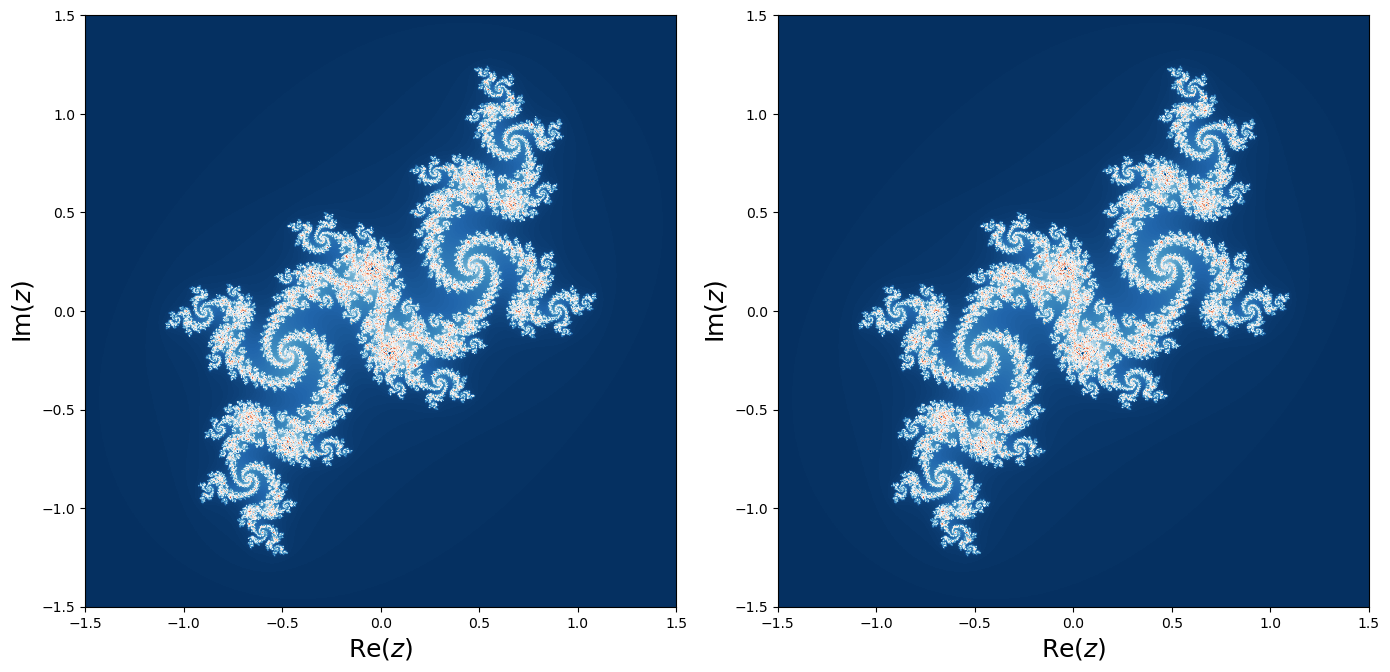

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(14, 14))
axes[0].imshow(j1, cmap=plt.cm.RdBu_r,
          extent=[-1.5, 1.5, -1.5, 1.5])
axes[0].set_xlabel("$\mathrm{Re}(z)$", fontsize=18)
axes[0].set_ylabel("$\mathrm{Im}(z)$", fontsize=18)
axes[1].imshow(j2, cmap=plt.cm.RdBu_r,
          extent=[-1.5, 1.5, -1.5, 1.5])
axes[1].set_xlabel("$\mathrm{Re}(z)$", fontsize=18)
axes[1].set_ylabel("$\mathrm{Im}(z)$", fontsize=18)
fig.tight_layout()

## Calling C function

In [124]:
%%cython

cdef extern from "math.h":
     double acos(double)

def cy_acos1(double x):
    return acos(x)

In [125]:
%timeit cy_acos1(0.5)

32.2 ns ± 0.0402 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [126]:
%%cython

from libc.math cimport acos

def cy_acos2(double x):
    return acos(x)

In [127]:
%timeit cy_acos2(0.5)

31.5 ns ± 0.0371 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [128]:
from numpy import arccos

In [129]:
%timeit arccos(0.5)

444 ns ± 8.64 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [130]:
from math import acos

In [131]:
%timeit acos(0.5)

40 ns ± 1.26 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [132]:
assert cy_acos1(0.5) == acos(0.5)

In [133]:
assert cy_acos2(0.5) == acos(0.5)

# Versions

In [1]:
%reload_ext version_information

In [2]:
%version_information numpy, cython, numba, matplotlib

Software versions
Python 3.10.12 64bit [Clang 14.0.6 ]
IPython 8.12.0
OS macOS 10.15.7 x86_64 i386 64bit
numpy 1.22.3
cython 3.0.0
numba 0.58.0
matplotlib 3.7.1
Sun Nov 03 19:47:42 2024 JST